In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv...
Preprocessing training text...
Calculating majority vote for training labels...

Training class distribution:
label_class
0.0    5269
1.0    1262
Name: count, dtype: int64
Class distribution plot saved as 'training_class_distribution.png'

Creating and training the SVM model...
SVM model training complete!

Reading test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l1.csv...
Preprocessing test text...
Calculating majority vote for test labels...
Making predictions on test data...

Evaluating model performance...

Macro F1 Score: 0.6807

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.83      0.85       877
         1.0       0.46      0.56      0.51       230

    accuracy                           0.77      1107
   macro avg       0.67      0.70      0.68      1107
weighted avg       0.79      0.77     

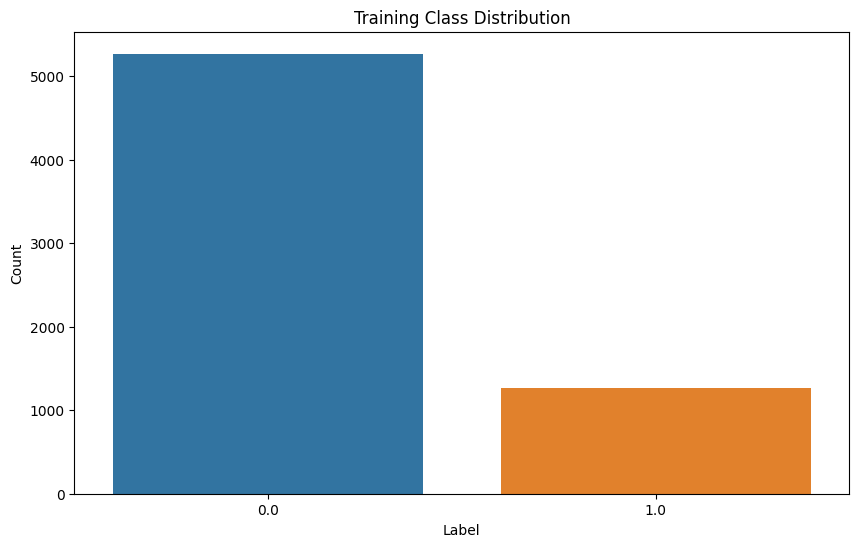

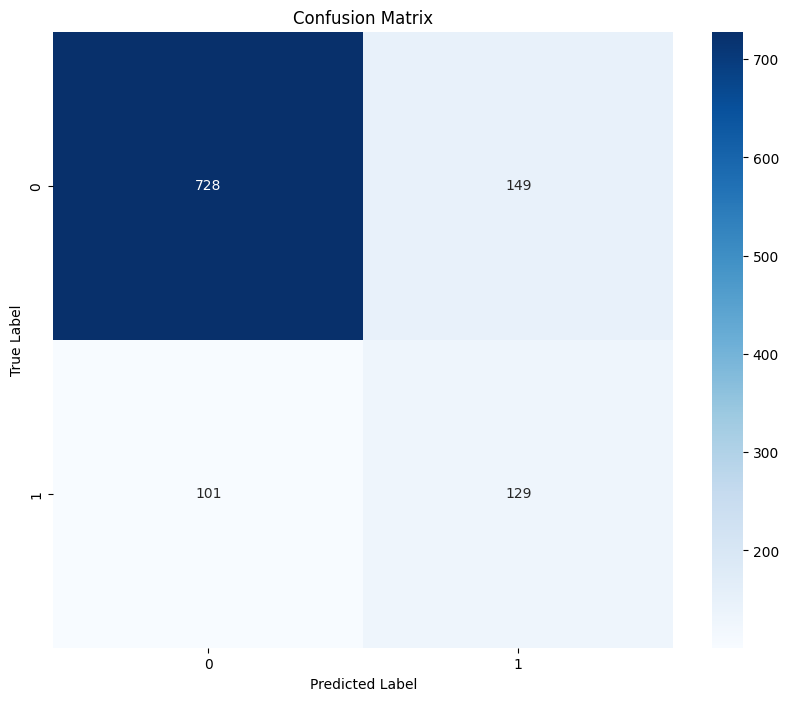

In [1]:
import pandas as pd
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC  # SVM classifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import joblib
import os

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess English text
def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize, remove stopwords and lemmatize (optional - can be computational intensive)
    # Uncomment if you want this feature
    '''
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    '''
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Function to calculate majority vote
def majority_vote(row):
    # Extract annotation columns - adjust these column names for your English dataset
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5','en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_english_classifier(train_file, test_file=None):
    """
    Train an English text classifier using SVM and evaluate on test data.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file
        print(f"Reading training data from {train_file}...")
        train_df = pd.read_csv(train_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_english_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('training_class_distribution.png')
        print("Class distribution plot saved as 'training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Create a pipeline with TF-IDF and SVM - optimized for English
        print("\nCreating and training the SVM model...")
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(
                max_features=10000,
                ngram_range=(1, 2),    # Unigrams and bigrams for English
                min_df=2,              # Ignore terms that appear in less than 2 documents
                max_df=0.95,           # Ignore terms that appear in more than 95% of documents
                stop_words='english',  # Remove English stopwords
                sublinear_tf=True      # Apply sublinear tf scaling
            )),
            ('classifier', SVC(
                C=1.0,                 # Regularization parameter
                kernel='linear',       # Linear kernel for text classification
                gamma='auto',          # Kernel coefficient
                probability=True,      # Enable probability estimates
                class_weight='balanced', # Handle class imbalance
                random_state=42
            ))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        print("SVM model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess test text
            print("Preprocessing test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_english_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('confusion_matrix.png')
            print("Confusion matrix saved as 'confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('test_predictions.csv', index=False)
            print("Test predictions saved to 'test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence (probability of the predicted class)
        confidence_values = []
        for i, pred_class in enumerate(predictions_class):
            class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
            confidence_values.append(prediction_probs[i][class_index])
        
        df['prediction_confidence'] = confidence_values
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def save_model(model, model_path='english_svm_classifier_model.pkl'):
    """
    Save the trained model to a file
    
    Args:
        model: Trained classifier pipeline
        model_path: Path where to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        joblib.dump(model, model_path)
        print(f"Model saved successfully to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model_and_predict(model_path='english_svm_classifier_model.pkl', 
                          test_file=None, sample_text=None):
    """
    Load a trained model and use it for inference on a test file or sample text
    
    Args:
        model_path: Path to the saved model file
        test_file: Path to a CSV file containing texts to predict
        sample_text: A single text string to predict
        
    Returns:
        Predictions or a single prediction
    """
    try:
        # Load the model
        print(f"Loading model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        
        if test_file and os.path.exists(test_file):
            # Predict on test file
            print(f"Predicting on test file: {test_file}")
            df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess text
            df['processed_text'] = df['text'].apply(preprocess_english_text)
            
            # Make predictions
            predictions_class = model.predict(df['processed_text'])
            predictions_value = [float(pred) for pred in predictions_class]
            
            # Get prediction probabilities
            prediction_probs = model.predict_proba(df['processed_text'])
            
            # Add predictions to dataframe
            df['predicted_label_class'] = predictions_class
            df['predicted_label_value'] = predictions_value
            
            # Add prediction confidence
            confidence_values = []
            for i, pred_class in enumerate(predictions_class):
                class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
                confidence_values.append(prediction_probs[i][class_index])
            
            df['prediction_confidence'] = confidence_values
            
            # Save results
            output_file = "svm_predictions_output.csv"
            df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")
            
            return df
            
        elif sample_text:
            # Predict on a single text
            print("Predicting on sample text...")
            processed_text = preprocess_english_text(sample_text)
            prediction_class = model.predict([processed_text])[0]
            prediction_value = float(prediction_class)
            
            # Get prediction probability
            prediction_prob = model.predict_proba([processed_text])[0]
            class_index = list(model.named_steps['classifier'].classes_).index(prediction_class)
            confidence = prediction_prob[class_index]
            
            print(f"Text: {sample_text}")
            print(f"Processed text: {processed_text}")
            print(f"Prediction (class): {prediction_class}")
            print(f"Prediction (value): {prediction_value}")
            print(f"Confidence: {confidence:.4f}")
            
            return prediction_class, prediction_value, confidence
        
        else:
            print("Error: Please provide either a test file or sample text.")
            return None
            
    except Exception as e:
        print(f"Error during inference: {e}")
        import traceback
        traceback.print_exc()
        return None

# Example usage
if __name__ == "__main__":
    # Example 1: Train and save model
    model, f1, report = train_english_classifier("/kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv", "/kaggle/input/capstone/uli_dataset-main/testing/test_en_l1.csv")
    if model:
        save_model(model, "english_svm_classifier_l1.pkl")
    
    # Example 2: Load model and predict
    # loaded_model = load_model_and_predict("english_svm_classifier.pkl", sample_text="This is a test message")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l2.csv...
Preprocessing training text...
Calculating majority vote for training labels...

Training class distribution:
label_class
0.0    4538
1.0    1993
Name: count, dtype: int64
Class distribution plot saved as 'training_class_distribution.png'

Creating and training the SVM model...
SVM model training complete!

Reading test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l2.csv...
Preprocessing test text...
Calculating majority vote for test labels...
Making predictions on test data...

Evaluating model performance...

Macro F1 Score: 0.6297

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73       716
         1.0       0.52      0.54      0.53       391

    accuracy                           0.66      1107
   macro avg       0.63      0.63      0.63      1107
weighted avg       0.66      0.66     

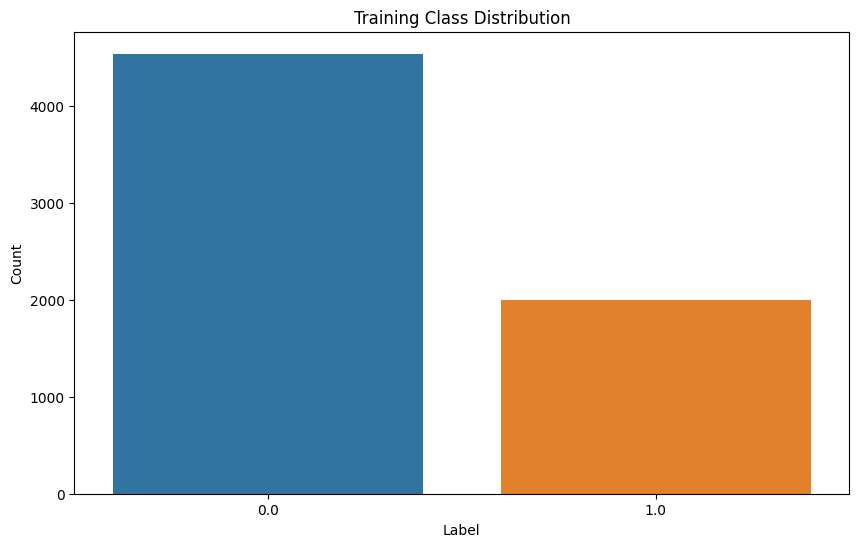

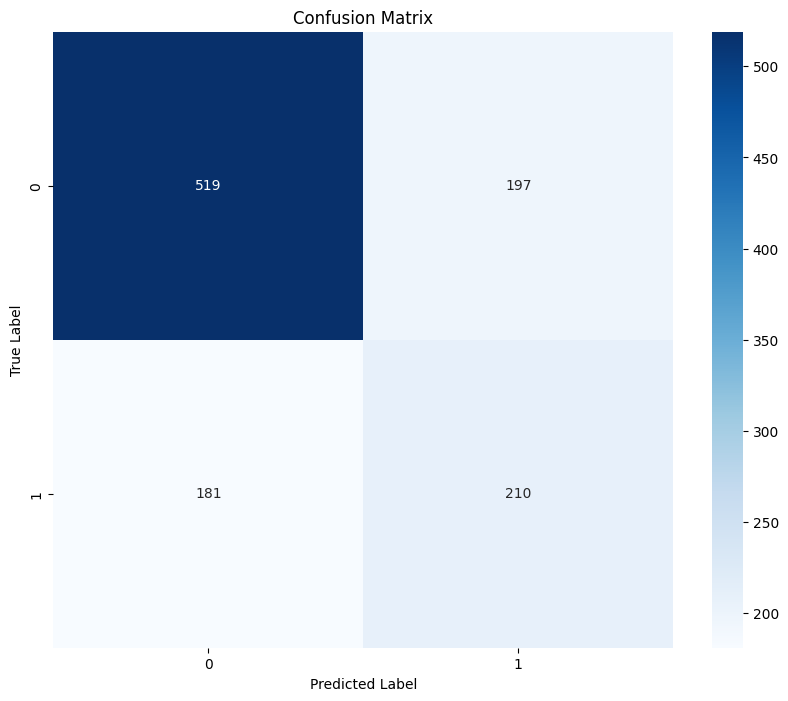

In [2]:
import pandas as pd
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC  # SVM classifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import joblib
import os

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess English text
def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize, remove stopwords and lemmatize (optional - can be computational intensive)
    # Uncomment if you want this feature
    '''
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    '''
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Function to calculate majority vote
def majority_vote(row):
    # Extract annotation columns - adjust these column names for your English dataset
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5','en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_english_classifier(train_file, test_file=None):
    """
    Train an English text classifier using SVM and evaluate on test data.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file
        print(f"Reading training data from {train_file}...")
        train_df = pd.read_csv(train_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_english_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('training_class_distribution.png')
        print("Class distribution plot saved as 'training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Create a pipeline with TF-IDF and SVM - optimized for English
        print("\nCreating and training the SVM model...")
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(
                max_features=10000,
                ngram_range=(1, 2),    # Unigrams and bigrams for English
                min_df=2,              # Ignore terms that appear in less than 2 documents
                max_df=0.95,           # Ignore terms that appear in more than 95% of documents
                stop_words='english',  # Remove English stopwords
                sublinear_tf=True      # Apply sublinear tf scaling
            )),
            ('classifier', SVC(
                C=1.0,                 # Regularization parameter
                kernel='linear',       # Linear kernel for text classification
                gamma='auto',          # Kernel coefficient
                probability=True,      # Enable probability estimates
                class_weight='balanced', # Handle class imbalance
                random_state=42
            ))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        print("SVM model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess test text
            print("Preprocessing test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_english_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('confusion_matrix.png')
            print("Confusion matrix saved as 'confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('test_predictions.csv', index=False)
            print("Test predictions saved to 'test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence (probability of the predicted class)
        confidence_values = []
        for i, pred_class in enumerate(predictions_class):
            class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
            confidence_values.append(prediction_probs[i][class_index])
        
        df['prediction_confidence'] = confidence_values
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def save_model(model, model_path='english_svm_classifier_model.pkl'):
    """
    Save the trained model to a file
    
    Args:
        model: Trained classifier pipeline
        model_path: Path where to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        joblib.dump(model, model_path)
        print(f"Model saved successfully to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model_and_predict(model_path='english_svm_classifier_model.pkl', 
                          test_file=None, sample_text=None):
    """
    Load a trained model and use it for inference on a test file or sample text
    
    Args:
        model_path: Path to the saved model file
        test_file: Path to a CSV file containing texts to predict
        sample_text: A single text string to predict
        
    Returns:
        Predictions or a single prediction
    """
    try:
        # Load the model
        print(f"Loading model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        
        if test_file and os.path.exists(test_file):
            # Predict on test file
            print(f"Predicting on test file: {test_file}")
            df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess text
            df['processed_text'] = df['text'].apply(preprocess_english_text)
            
            # Make predictions
            predictions_class = model.predict(df['processed_text'])
            predictions_value = [float(pred) for pred in predictions_class]
            
            # Get prediction probabilities
            prediction_probs = model.predict_proba(df['processed_text'])
            
            # Add predictions to dataframe
            df['predicted_label_class'] = predictions_class
            df['predicted_label_value'] = predictions_value
            
            # Add prediction confidence
            confidence_values = []
            for i, pred_class in enumerate(predictions_class):
                class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
                confidence_values.append(prediction_probs[i][class_index])
            
            df['prediction_confidence'] = confidence_values
            
            # Save results
            output_file = "svm_predictions_output.csv"
            df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")
            
            return df
            
        elif sample_text:
            # Predict on a single text
            print("Predicting on sample text...")
            processed_text = preprocess_english_text(sample_text)
            prediction_class = model.predict([processed_text])[0]
            prediction_value = float(prediction_class)
            
            # Get prediction probability
            prediction_prob = model.predict_proba([processed_text])[0]
            class_index = list(model.named_steps['classifier'].classes_).index(prediction_class)
            confidence = prediction_prob[class_index]
            
            print(f"Text: {sample_text}")
            print(f"Processed text: {processed_text}")
            print(f"Prediction (class): {prediction_class}")
            print(f"Prediction (value): {prediction_value}")
            print(f"Confidence: {confidence:.4f}")
            
            return prediction_class, prediction_value, confidence
        
        else:
            print("Error: Please provide either a test file or sample text.")
            return None
            
    except Exception as e:
        print(f"Error during inference: {e}")
        import traceback
        traceback.print_exc()
        return None

# Example usage
if __name__ == "__main__":
    # Example 1: Train and save model
    model, f1, report = train_english_classifier("/kaggle/input/capstone/uli_dataset-main/training/train_en_l2.csv", "/kaggle/input/capstone/uli_dataset-main/testing/test_en_l2.csv")
    if model:
        save_model(model, "english_svm_classifier_l2.pkl")
    
    # Example 2: Load model and predict
    # loaded_model = load_model_and_predict("english_svm_classifier.pkl", sample_text="This is a test message")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv...
Preprocessing training text...
Calculating majority vote for training labels...

Training class distribution:
label_class
0.0    4309
1.0    2222
Name: count, dtype: int64
Class distribution plot saved as 'training_class_distribution.png'

Creating and training the SVM model...
SVM model training complete!

Reading test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l3.csv...
Preprocessing test text...
Calculating majority vote for test labels...
Making predictions on test data...

Evaluating model performance...

Macro F1 Score: 0.6309

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.66      0.70       699
         1.0       0.51      0.62      0.56       408

    accuracy                           0.64      1107
   macro avg       0.63      0.64      0.63      1107
weighted avg       0.66      0.64     

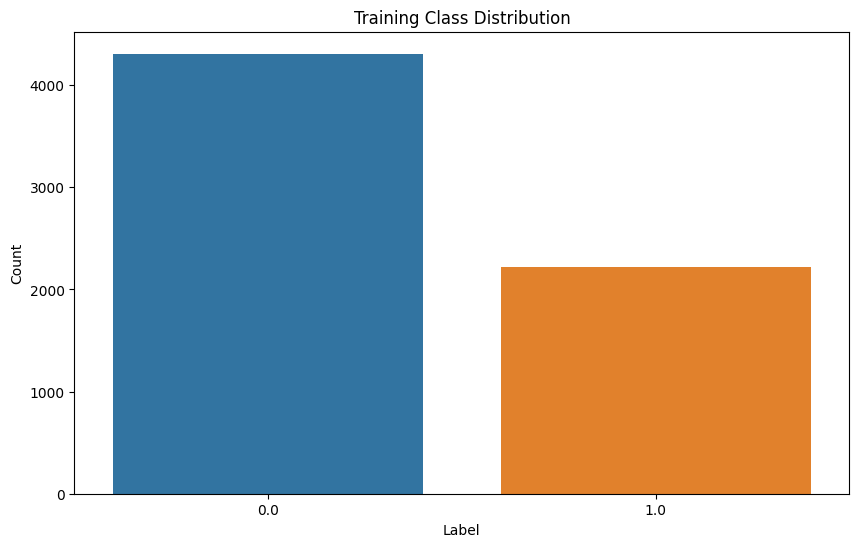

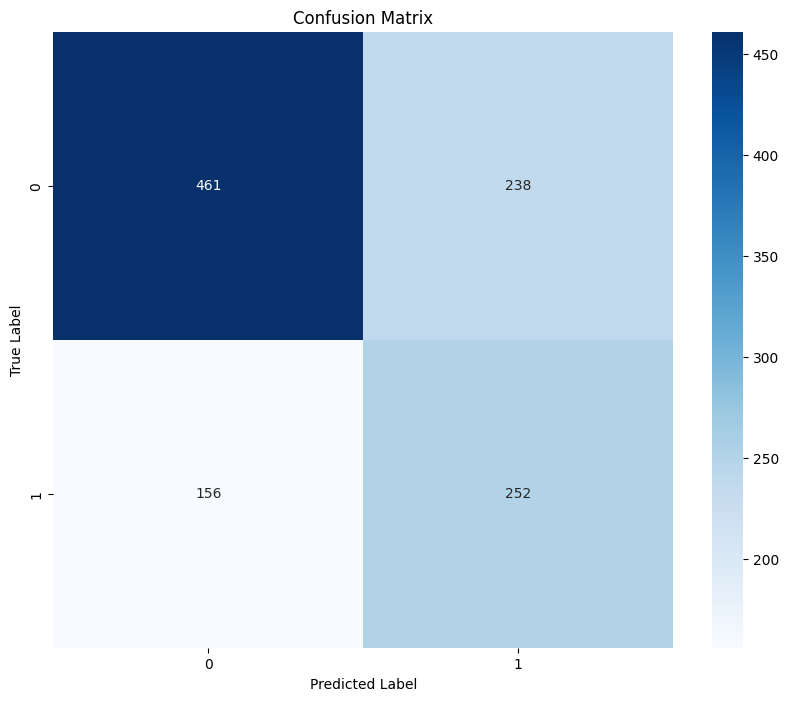

In [3]:
import pandas as pd
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC  # SVM classifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import joblib
import os

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess English text
def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize, remove stopwords and lemmatize (optional - can be computational intensive)
    # Uncomment if you want this feature
    '''
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    '''
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Function to calculate majority vote
def majority_vote(row):
    # Extract annotation columns - adjust these column names for your English dataset
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5','en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_english_classifier(train_file, test_file=None):
    """
    Train an English text classifier using SVM and evaluate on test data.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file
        print(f"Reading training data from {train_file}...")
        train_df = pd.read_csv(train_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_english_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('training_class_distribution.png')
        print("Class distribution plot saved as 'training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Create a pipeline with TF-IDF and SVM - optimized for English
        print("\nCreating and training the SVM model...")
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(
                max_features=10000,
                ngram_range=(1, 2),    # Unigrams and bigrams for English
                min_df=2,              # Ignore terms that appear in less than 2 documents
                max_df=0.95,           # Ignore terms that appear in more than 95% of documents
                stop_words='english',  # Remove English stopwords
                sublinear_tf=True      # Apply sublinear tf scaling
            )),
            ('classifier', SVC(
                C=1.0,                 # Regularization parameter
                kernel='linear',       # Linear kernel for text classification
                gamma='auto',          # Kernel coefficient
                probability=True,      # Enable probability estimates
                class_weight='balanced', # Handle class imbalance
                random_state=42
            ))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        print("SVM model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess test text
            print("Preprocessing test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_english_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('confusion_matrix.png')
            print("Confusion matrix saved as 'confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('test_predictions.csv', index=False)
            print("Test predictions saved to 'test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence (probability of the predicted class)
        confidence_values = []
        for i, pred_class in enumerate(predictions_class):
            class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
            confidence_values.append(prediction_probs[i][class_index])
        
        df['prediction_confidence'] = confidence_values
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def save_model(model, model_path='english_svm_classifier_model.pkl'):
    """
    Save the trained model to a file
    
    Args:
        model: Trained classifier pipeline
        model_path: Path where to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        joblib.dump(model, model_path)
        print(f"Model saved successfully to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model_and_predict(model_path='english_svm_classifier_model.pkl', 
                          test_file=None, sample_text=None):
    """
    Load a trained model and use it for inference on a test file or sample text
    
    Args:
        model_path: Path to the saved model file
        test_file: Path to a CSV file containing texts to predict
        sample_text: A single text string to predict
        
    Returns:
        Predictions or a single prediction
    """
    try:
        # Load the model
        print(f"Loading model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        
        if test_file and os.path.exists(test_file):
            # Predict on test file
            print(f"Predicting on test file: {test_file}")
            df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess text
            df['processed_text'] = df['text'].apply(preprocess_english_text)
            
            # Make predictions
            predictions_class = model.predict(df['processed_text'])
            predictions_value = [float(pred) for pred in predictions_class]
            
            # Get prediction probabilities
            prediction_probs = model.predict_proba(df['processed_text'])
            
            # Add predictions to dataframe
            df['predicted_label_class'] = predictions_class
            df['predicted_label_value'] = predictions_value
            
            # Add prediction confidence
            confidence_values = []
            for i, pred_class in enumerate(predictions_class):
                class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
                confidence_values.append(prediction_probs[i][class_index])
            
            df['prediction_confidence'] = confidence_values
            
            # Save results
            output_file = "svm_predictions_output.csv"
            df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")
            
            return df
            
        elif sample_text:
            # Predict on a single text
            print("Predicting on sample text...")
            processed_text = preprocess_english_text(sample_text)
            prediction_class = model.predict([processed_text])[0]
            prediction_value = float(prediction_class)
            
            # Get prediction probability
            prediction_prob = model.predict_proba([processed_text])[0]
            class_index = list(model.named_steps['classifier'].classes_).index(prediction_class)
            confidence = prediction_prob[class_index]
            
            print(f"Text: {sample_text}")
            print(f"Processed text: {processed_text}")
            print(f"Prediction (class): {prediction_class}")
            print(f"Prediction (value): {prediction_value}")
            print(f"Confidence: {confidence:.4f}")
            
            return prediction_class, prediction_value, confidence
        
        else:
            print("Error: Please provide either a test file or sample text.")
            return None
            
    except Exception as e:
        print(f"Error during inference: {e}")
        import traceback
        traceback.print_exc()
        return None

# Example usage
if __name__ == "__main__":
    # Example 1: Train and save model
    model, f1, report = train_english_classifier("/kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv", "/kaggle/input/capstone/uli_dataset-main/testing/test_en_l3.csv")
    if model:
        save_model(model, "english_svm_classifier_l3.pkl")
    
    # Example 2: Load model and predict
    # loaded_model = load_model_and_predict("english_svm_classifier.pkl", sample_text="This is a test message")

In [11]:
import pandas as pd
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC  # Change from LogisticRegression to SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import joblib
import os

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess English text
def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Function to calculate majority vote for L1 dataset
def majority_vote_l1(row):
    # Extract annotation columns for L1
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

# Function to calculate majority vote for L3 dataset
def majority_vote_l3(row):
    # Extract annotation columns for L3
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_combined_classifier_svm(l1_file, l3_file):
    """
    Combine L1 and L3 datasets, train an SVM model, and evaluate.
    Final label is 1 if both L1 and L3 are 1, otherwise 0.
    
    Args:
        l1_file: Path to the L1 CSV file
        l3_file: Path to the L3 CSV file
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the L1 CSV file
        print(f"Reading L1 data from {l1_file}...")
        l1_df = pd.read_csv(l1_file, quoting=csv.QUOTE_MINIMAL)
        
        # Read the L3 CSV file
        print(f"Reading L3 data from {l3_file}...")
        l3_df = pd.read_csv(l3_file, quoting=csv.QUOTE_MINIMAL)
        
        # Ensure both datasets have a unique ID to match sentences
        if 'id' not in l1_df.columns:
            l1_df['id'] = range(len(l1_df))
        if 'id' not in l3_df.columns:
            l3_df['id'] = range(len(l3_df))
        
        # Calculate majority vote for L1 dataset
        print("Calculating majority vote for L1 labels...")
        l1_df['l1_label'] = l1_df.apply(majority_vote_l1, axis=1)
        
        # Calculate majority vote for L3 dataset
        print("Calculating majority vote for L3 labels...")
        l3_df['l3_label'] = l3_df.apply(majority_vote_l3, axis=1)
        
        # Extract essential columns from each dataset
        l1_subset = l1_df[['id', 'text', 'l1_label']]
        l3_subset = l3_df[['id', 'l3_label']]
        
        # Merge datasets on ID
        print("Merging L1 and L3 datasets...")
        merged_df = pd.merge(l1_subset, l3_subset, on='id', how='inner')
        
        # Determine final label: 1 if both L1 and L3 are 1, otherwise 0
        merged_df['final_label'] = ((merged_df['l1_label'] == 1.0) & 
                                    (merged_df['l3_label'] == 1.0)).astype(int)
        
        # Preprocess text column
        print("Preprocessing text...")
        merged_df['processed_text'] = merged_df['text'].apply(preprocess_english_text)
        
        # Print the class distribution
        print("\nFinal label class distribution:")
        class_dist = merged_df['final_label'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='final_label', data=merged_df)
        plt.title('Combined Dataset Class Distribution')
        plt.xlabel('Final Label (1 if both L1 and L3 are 1, otherwise 0)')
        plt.ylabel('Count')
        plt.savefig('combined_class_distribution_svm.png')
        print("Class distribution plot saved as 'combined_class_distribution_svm.png'")
        
        # Split into training and testing sets (80% train, 20% test)
        X = merged_df['processed_text']
        y = merged_df['final_label']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print(f"Training data size: {len(X_train)}, Test data size: {len(X_test)}")
        
        # Create a pipeline with TF-IDF and SVM
        print("\nCreating and training the model...")
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(
                max_features=10000,
                ngram_range=(1, 2),    # Unigrams and bigrams
                min_df=2,              # Ignore terms that appear in less than 2 documents
                max_df=0.95,           # Ignore terms that appear in more than 95% of documents
                stop_words='english',  # Remove English stopwords
                sublinear_tf=True      # Apply sublinear tf scaling
            )),
            ('classifier', SVC(
                C=1.0,                 # Regularization parameter
                kernel='linear',       # Linear kernel (for feature importance)
                gamma='scale',         # Kernel coefficient
                class_weight='balanced', # Handle class imbalance
                random_state=42,       # For reproducibility
                probability=True       # Enable probability estimates
            ))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        print("Model training complete!")
        
        # Skip feature importance for now to avoid the error
        # We'll just proceed with the predictions and evaluation
        
        # Make predictions on test data
        print("\nMaking predictions on test data...")
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        print("\nEvaluating model performance...")
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        
        print(f"\nMacro F1 Score: {macro_f1:.4f}")
        print("\nDetailed Classification Report:")
        report = classification_report(y_test, y_pred)
        print(report)
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (SVM)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig('confusion_matrix_svm.png')
        print("Confusion matrix saved as 'confusion_matrix_svm.png'")
        
        # Save test predictions
        print("\nSaving test predictions...")
        results_df = pd.DataFrame({
            'text': X_test.values,
            'true_label': y_test.values,
            'predicted_label': y_pred,
            'probability_class_1': pipeline.predict_proba(X_test)[:, 1]
        })
        results_df.to_csv('test_predictions_svm.csv', index=False)
        print("Test predictions saved to 'test_predictions_svm.csv'")
        
        # Save the combined dataset with all labels
        merged_df.to_csv('combined_dataset_with_labels_svm.csv', index=False)
        print("Combined dataset saved to 'combined_dataset_with_labels_svm.csv'")
        
        return pipeline, macro_f1, report
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None
# Function to predict on new data
def predict_on_new_data_svm(model, input_file, output_file):
    """
    Use a trained SVM model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions...")
        predictions = model.predict(df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(df['processed_text'])
        
        # Add predictions to dataframe
        df['predicted_label'] = predictions
        df['probability_class_1'] = prediction_probs[:, 1]
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions).value_counts()
        print(pred_dist)
        
        # Plot probability distribution
        plt.figure(figsize=(10, 6))
        plt.hist(df['probability_class_1'], bins=20)
        plt.title('Prediction Probability Distribution (Class 1)')
        plt.xlabel('Probability')
        plt.ylabel('Count')
        plt.savefig('prediction_probability_svm.png')
        print("Prediction probability plot saved as 'prediction_probability_svm.png'")
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def evaluate_on_combined_test_data_svm(model, l1_test_file, l3_test_file, output_file='combined_test_predictions_svm.csv'):
    """
    Combine L1 and L3 test datasets, evaluate the SVM model, and save predictions.
    Final label is 1 if both L1 and L3 are 1, otherwise 0.
    
    Args:
        model: Trained classifier pipeline
        l1_test_file: Path to the L1 test CSV file
        l3_test_file: Path to the L3 test CSV file
        output_file: Path to save predictions
    
    Returns:
        Evaluation metrics and combined test dataframe
    """
    try:
        # Read the L1 test CSV file
        print(f"Reading L1 test data from {l1_test_file}...")
        l1_test_df = pd.read_csv(l1_test_file, quoting=csv.QUOTE_MINIMAL)
        
        # Read the L3 test CSV file
        print(f"Reading L3 test data from {l3_test_file}...")
        l3_test_df = pd.read_csv(l3_test_file, quoting=csv.QUOTE_MINIMAL)
        
        # Ensure both datasets have a unique ID to match sentences
        if 'id' not in l1_test_df.columns:
            l1_test_df['id'] = range(len(l1_test_df))
        if 'id' not in l3_test_df.columns:
            l3_test_df['id'] = range(len(l3_test_df))
        
        # Calculate majority vote for L1 test dataset
        print("Calculating majority vote for L1 test labels...")
        l1_test_df['l1_label'] = l1_test_df.apply(majority_vote_l1, axis=1)
        
        # Calculate majority vote for L3 test dataset
        print("Calculating majority vote for L3 test labels...")
        l3_test_df['l3_label'] = l3_test_df.apply(majority_vote_l3, axis=1)
        
        # Extract essential columns from each test dataset
        l1_test_subset = l1_test_df[['id', 'text', 'l1_label']]
        l3_test_subset = l3_test_df[['id', 'l3_label']]
        
        # Merge test datasets on ID
        print("Merging L1 and L3 test datasets...")
        merged_test_df = pd.merge(l1_test_subset, l3_test_subset, on='id', how='inner')
        
        # Determine final test label: 1 if both L1 and L3 are 1, otherwise 0
        merged_test_df['final_label'] = ((merged_test_df['l1_label'] == 1.0) & 
                                       (merged_test_df['l3_label'] == 1.0)).astype(int)
        
        # Preprocess text column
        print("Preprocessing test text...")
        merged_test_df['processed_text'] = merged_test_df['text'].apply(preprocess_english_text)
        
        # Print the test class distribution
        print("\nFinal test label class distribution:")
        test_class_dist = merged_test_df['final_label'].value_counts()
        print(test_class_dist)
        
        # Plot test class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='final_label', data=merged_test_df)
        plt.title('Combined Test Dataset Class Distribution')
        plt.xlabel('Final Label (1 if both L1 and L3 are 1, otherwise 0)')
        plt.ylabel('Count')
        plt.savefig('combined_test_class_distribution_svm.png')
        print("Test class distribution plot saved as 'combined_test_class_distribution_svm.png'")
        
        # Get test data
        X_test = merged_test_df['processed_text']
        y_test = merged_test_df['final_label']
        
        print(f"Test data size: {len(X_test)}")
        if model is None:
            print("Error: Model is None. Please ensure the model was trained successfully.")
            return None, None, None
            
        # Get test data
        X_test = merged_test_df['processed_text']
        y_test = merged_test_df['final_label']
        
        print(f"Test data size: {len(X_test)}")
        
        # Make predictions on test data
        print("\nMaking predictions on combined test data...")
        y_pred = model.predict(X_test)
        
        
        # Calculate metrics
        print("\nEvaluating model performance on test data...")
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        
        print(f"\nMacro F1 Score on test data: {macro_f1:.4f}")
        print("\nDetailed Classification Report on test data:")
        test_report = classification_report(y_test, y_pred)
        print(test_report)
        
        # Create confusion matrix for test data
        test_cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Test Data Confusion Matrix (SVM)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig('test_confusion_matrix_svm.png')
        print("Test confusion matrix saved as 'test_confusion_matrix_svm.png'")
        
        # Save test predictions
        print("\nSaving combined test predictions...")
        results_df = pd.DataFrame({
            'id': merged_test_df['id'],
            'text': X_test.values,
            'l1_label': merged_test_df['l1_label'],
            'l3_label': merged_test_df['l3_label'],
            'true_combined_label': y_test.values,
            'predicted_label': y_pred,
            'probability_class_1': model.predict_proba(X_test)[:, 1]
        })
        results_df.to_csv(output_file, index=False)
        print(f"Combined test predictions saved to '{output_file}'")
        
        # Plot probability distribution for test data
        plt.figure(figsize=(10, 6))
        plt.hist(results_df['probability_class_1'], bins=20)
        plt.title('Test Prediction Probability Distribution (Class 1)')
        plt.xlabel('Probability')
        plt.ylabel('Count')
        plt.savefig('test_prediction_probability_svm.png')
        print("Test prediction probability plot saved as 'test_prediction_probability_svm.png'")
        
        return macro_f1, test_report, results_df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# Function to save the trained model
def save_model(model, model_path='trained_combined_classifier_svm.joblib'):
    """
    Save the trained model to disk.
    
    Args:
        model: Trained classifier pipeline
        model_path: Path to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(model_path) if os.path.dirname(model_path) else '.', exist_ok=True)
        # Save the model
        joblib.dump(model, model_path)
        print(f"Model successfully saved to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        import traceback
        traceback.print_exc()
        return False

# Function to load a saved model and perform inference
def load_model_and_predict(model_path, text_samples):
    """
    Load a trained model and make predictions on sample text.
    
    Args:
        model_path: Path to the saved model
        text_samples: List of text strings to predict on
        
    Returns:
        DataFrame with predictions
    """
    try:
        # Load the model
        print(f"Loading model from {model_path}...")
        try:
            model = joblib.load(model_path)
            if model is None:
                print("Error: Loaded model is None")
                return None
            print("Model loaded successfully!")
        except Exception as e:
            print(f"Error loading model: {e}")
            return None
        
        
        # Create a dataframe from the text samples
        samples_df = pd.DataFrame({'text': text_samples})
        
        # Preprocess the text
        print("Preprocessing sample text...")
        samples_df['processed_text'] = samples_df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions on samples...")
        predictions = model.predict(samples_df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(samples_df['processed_text'])
        
        # Add predictions to dataframe
        samples_df['predicted_label'] = predictions
        samples_df['probability_class_1'] = prediction_probs[:, 1]
        
        # Display results
        print("\nPrediction Results:")
        for i, (text, pred, prob) in enumerate(zip(
            text_samples, predictions, prediction_probs[:, 1])):
            label = "Potential issue detected" if pred == 1 else "No issue detected"
            print(f"\nSample {i+1}:")
            print(f"Text: {text[:100]}..." if len(text) > 100 else f"Text: {text}")
            print(f"Prediction: {label} (Class {pred})")
            print(f"Confidence: {prob:.4f}")
        
        return samples_df
        
    except Exception as e:
        print(f"Error during model loading or prediction: {e}")
        import traceback
        traceback.print_exc()
        return None

# Demonstration inference function
def demo_inference(model_path='trained_combined_classifier_svm.joblib'):
    """
    Demonstrate model inference with sample texts.
    
    Args:
        model_path: Path to the saved model
    """
    # Sample texts to test the model
    sample_texts = [
        "This restaurant would not serve me because of my race.",
        "I really enjoyed the movie, it was entertaining from start to finish.",
        "They refused to hire me because I'm too old for the position.",
        "The weather today is quite pleasant, perfect for a walk in the park.",
        "This company consistently pays women less than men for the same work."
    ]
    
    # Run inference
    results = load_model_and_predict(model_path, sample_texts)
    
    # Save results to CSV if available
    if results is not None:
        results.to_csv('sample_predictions_svm.csv', index=False)
        print("\nSample predictions saved to 'sample_predictions_svm.csv'")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reading L1 data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv...
Reading L3 data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv...
Calculating majority vote for L1 labels...
Calculating majority vote for L3 labels...
Merging L1 and L3 datasets...
Preprocessing text...

Final label class distribution:
final_label
0    5400
1    1131
Name: count, dtype: int64
Class distribution plot saved as 'combined_class_distribution_svm.png'
Training data size: 5224, Test data size: 1307

Creating and training the model...
Model training complete!
Error: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().
Saving model to svm_model_combined.joblib...
Model successfully saved to svm_model_combined.joblib
Reading L1 test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l1.csv...
Reading L3 test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l3.csv...
Calculating majority vote for L

Traceback (most recent call last):
  File "/tmp/ipykernel_31/3517045717.py", line 238, in train_combined_classifier_svm
    top_positive_features = [(feature_names[idx], coefficients[idx])
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_31/3517045717.py", line 239, in <listcomp>
    for idx in sorted_coef_idx[-10:] if coefficients[idx] > 0]
                                        ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/scipy/sparse/_base.py", line 417, in __bool__
    raise ValueError("The truth value of an array with more than one "
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().


Test class distribution plot saved as 'combined_test_class_distribution_svm.png'
Test data size: 1107

Making predictions on combined test data...
Error: 'NoneType' object has no attribute 'predict'
Loading model from svm_model_combined.joblib...
Model loaded successfully!
Preprocessing sample text...
Making predictions on samples...
Error during model loading or prediction: 'NoneType' object has no attribute 'predict'


Traceback (most recent call last):
  File "/tmp/ipykernel_31/3517045717.py", line 428, in evaluate_on_combined_test_data_svm
    y_pred = model.predict(X_test)
             ^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'predict'
Traceback (most recent call last):
  File "/tmp/ipykernel_31/3517045717.py", line 530, in load_model_and_predict
    predictions = model.predict(samples_df['processed_text'])
                  ^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'predict'


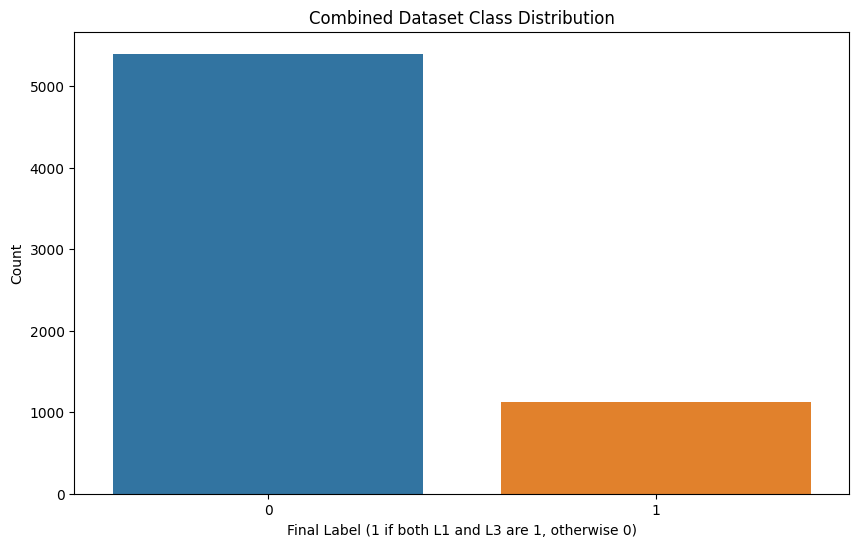

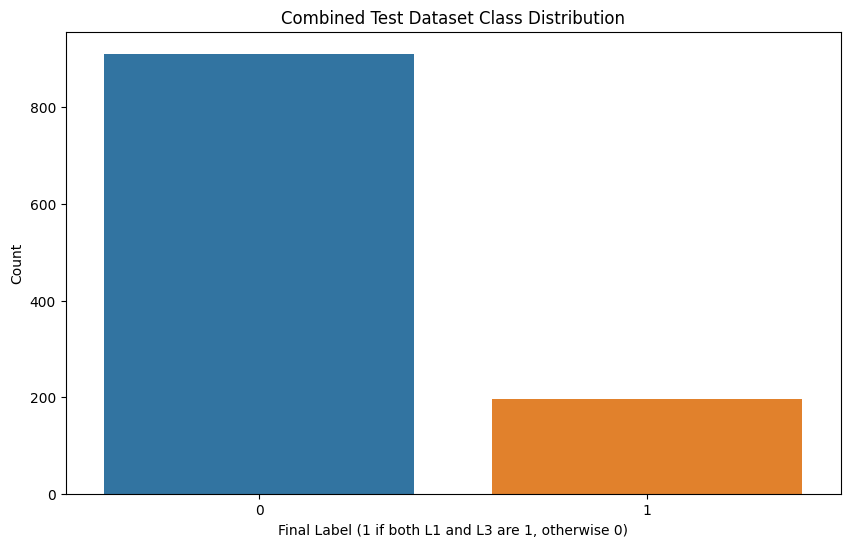

In [12]:
def main():
    """
    Main function to run the complete pipeline
    """
    try:
        # Train the model
        print("Training the SVM model...")
        model, f1, report = train_combined_classifier_svm('/kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv', '/kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv')
        
        # Check if model was successfully trained
        if model is None:
            print("Error: Model training failed!")
            return
            
        # Save the model
        print("Saving the trained model...")
        save_successful = save_model(model, 'svm_model_combined.joblib')
        
        if not save_successful:
            print("Error: Failed to save the model!")
            return
            
        # Evaluate on test data if available
        print("Evaluating on test data...")
        evaluate_on_combined_test_data_svm(model, '/kaggle/input/capstone/uli_dataset-main/testing/test_en_l1.csv', '/kaggle/input/capstone/uli_dataset-main/testing/test_en_l3.csv')
        
        # Run inference demo
        print("Running inference demo...")
        demo_inference('svm_model_combined.joblib')
        
        print("Pipeline completed successfully!")
        
    except Exception as e:
        print(f"Error in main function: {e}")
        import traceback
        traceback.print_exc()

Training the SVM model...
Reading L1 data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv...
Reading L3 data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv...
Calculating majority vote for L1 labels...
Calculating majority vote for L3 labels...
Merging L1 and L3 datasets...
Preprocessing text...

Final label class distribution:
final_label
0    5400
1    1131
Name: count, dtype: int64
Class distribution plot saved as 'combined_class_distribution_svm.png'
Training data size: 5224, Test data size: 1307

Creating and training the model...
Model training complete!

Making predictions on test data...

Evaluating model performance...

Macro F1 Score: 0.6473

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1081
           1       0.38      0.54      0.44       226

    accuracy                           0.76      1307
   macro avg       0.63      0.68      0.65 

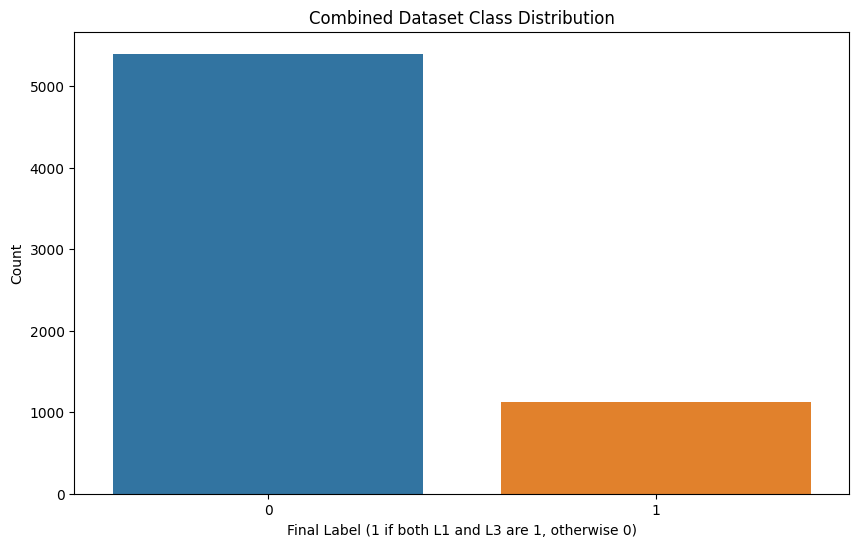

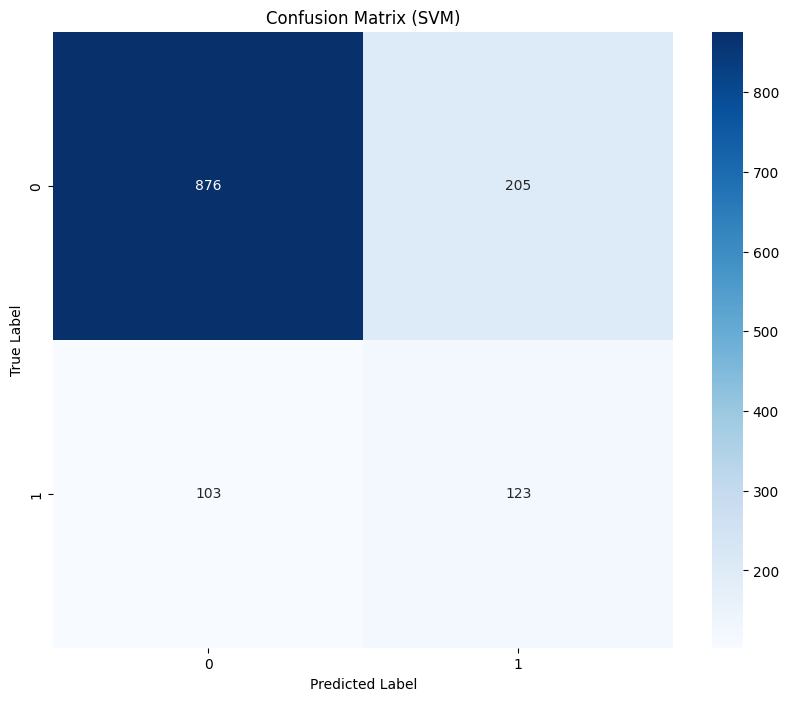

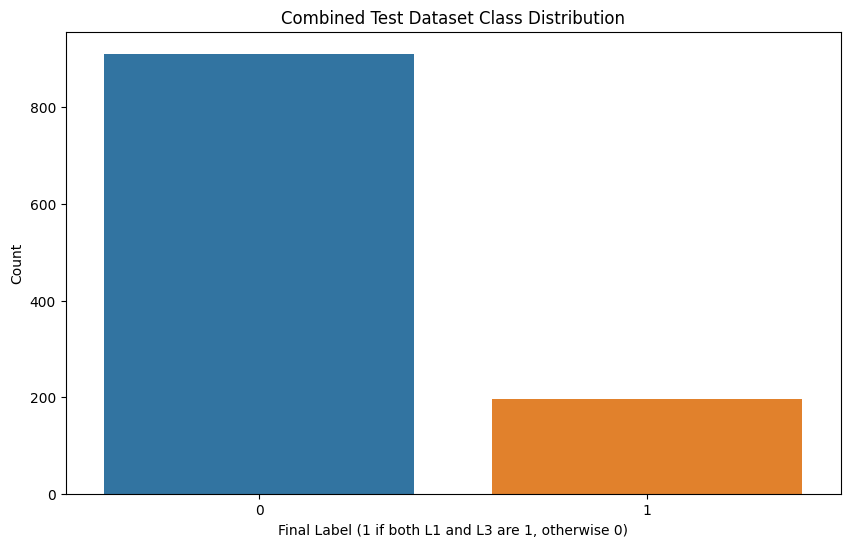

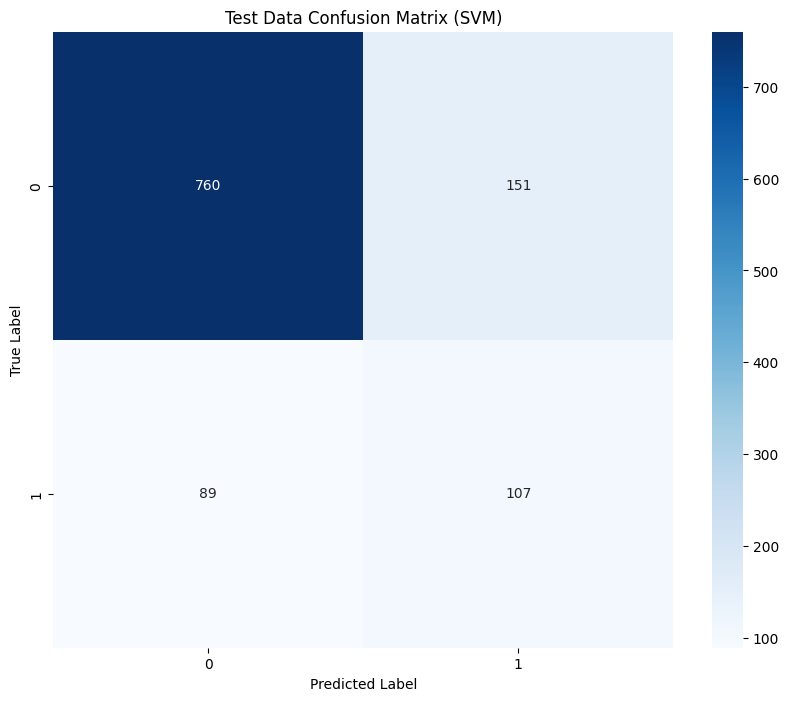

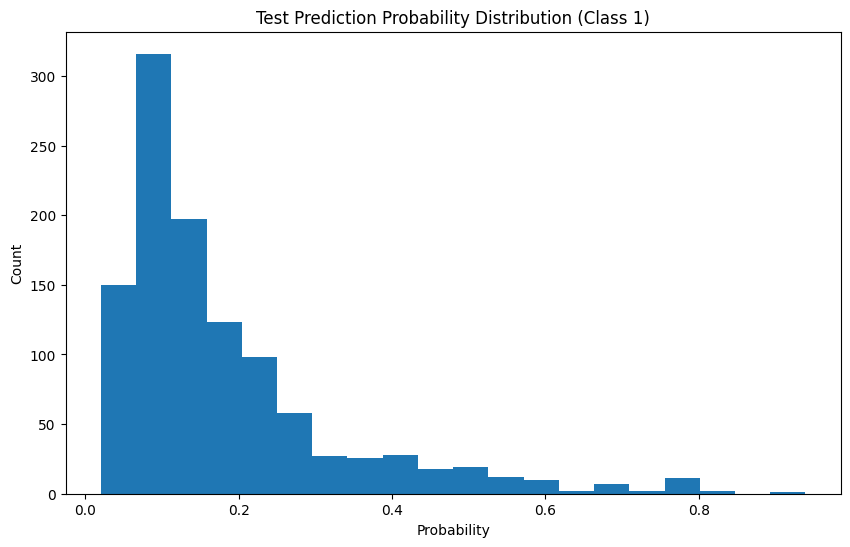

In [13]:
if __name__ == "__main__":
    main()